## MICCAI Test Pipeline

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-02-04 19:07:10.615990: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 19:07:12.086646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 19:07:13.781849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# overall imports
import importlib
import data

# importlib.reload(data.data_utils)
# importlib.reload(data.data_load)
#importlib.reload(sim.sim_utils)
# importlib.reload(models)

import models
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results, run_simulation_set


## Results visualization

In [4]:
# cross-validation classes
from data.cv_split import (
    RandomCVSplit, 
    SchaeferCVSplit, 
    CommunityCVSplit, 
    SubnetworkCVSplit, 
    SpatialCVSplit
)

schaefer_obj = SchaeferCVSplit()
print(list(schaefer_obj.networks.keys()))

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical']


In [5]:
model_types=['pls', 'xgboost', 'dynamic_mlp', 'random_forest', 'bilinear_lowrank', 'bilinear_SCM', 'shared_mlp_encoder', 'shared_linear_encoder', 'shared_transformer'],
model_types=['pls', 'xgboost', 'dynamic_mlp', 'bilinear_lowrank', 'shared_mlp_encoder', 'shared_linear_encoder', 'shared_transformer'],
cv_types=['spatial', 'random', 'schaefer'],
parcellations=['S100', 'S400'],
connectome_targets=['SC', 'FC'],
feature_types=['transcriptome', 'euclidean', 'transcriptome+euclidean'],
random_seeds=[1, 42], 


In [6]:
results_df = pd.read_csv('LM_Feb5_schaefer.csv')
print(results_df.shape)
results_df.head()

(197, 25)


,Name,Runtime,Hostname,Notes,GPU Type,Tags,config.epochs,config.input_dim,config.lambda_reg,config.learning_rate,...,final_test_metrics.r2,final_train_metrics.geodesic_distance,final_train_metrics.mae,final_train_metrics.mse,final_train_metrics.pearson_corr,final_train_metrics.r2,test_mse_loss,test_pearson,train_mse_loss,train_pearson
0,shared_transformer_transcriptome_SC_schaefer_f...,1,gh002.hpc.nyu.edu,-,NVIDIA H100 80GB HBM3,"cv_type_schaefer, feature_type_transcriptome, ...",100.0,10760.0,0.0,0.00009,...,0.705998,7.926983,0.596868,0.678995,0.968890,0.933147,4.500048,0.897115,1.527782,0.925650
1,dynamic_mlp_euclidean_SC_schaefer_fold4_final_...,1,ga014.hpc.nyu.edu,-,NVIDIA A100-SXM4-80GB,"cv_type_schaefer, feature_type_euclidean, fina...",150.0,6.0,NaN,0.00030,...,0.461514,13.336440,1.035324,4.839267,0.746537,0.523531,0.194001,0.844910,0.114952,0.694705
2,dynamic_mlp_euclidean_SC_schaefer_fold0_final_...,0,ga014.hpc.nyu.edu,-,NVIDIA A100-SXM4-80GB,"cv_type_schaefer, feature_type_euclidean, fina...",150.0,6.0,NaN,0.00030,...,0.648021,11.559418,1.188794,5.649902,0.732214,0.487099,0.183410,0.766497,0.130191,0.684160
3,shared_transformer_transcriptome+euclidean_SC_...,1,gh002.hpc.nyu.edu,-,NVIDIA H100 80GB HBM3,"cv_type_schaefer, feature_type_transcriptome+e...",200.0,10763.0,0.0,0.00010,...,0.041627,11.421215,1.100826,3.985900,0.785917,0.607552,14.669044,0.806222,2.368142,0.879899
4,dynamic_mlp_euclidean_SC_schaefer_fold1_final_...,1,ga014.hpc.nyu.edu,-,NVIDIA A100-SXM4-80GB,"cv_type_schaefer, feature_type_euclidean, fina...",150.0,6.0,NaN,0.00030,...,0.425576,11.291821,1.014763,4.517031,0.780781,0.576172,0.200543,0.773648,0.113964,0.735390


In [15]:
def get_best_runs(df, model_types, cv_type, connectome_target, feature_type, parcellation, metric='pearson_corr'):
    """
    Filter dataframe for specified criteria and get best performing run for each unique model.
    
    Args:
        df (pd.DataFrame): Input dataframe with results
        model_types (list): List of model types to include
        cv_type (str): Type of cross validation split
        connectome_target (str): Either 'SC' or 'FC'
        feature_type (str): Feature type to include (e.g. 'transcriptome')
        parcellation (str): Brain parcellation to use (e.g. 'S100')
        metric (str): Metric to use for selecting best run. Options: 'pearson_corr', 'r2', 'mse'
        
    Returns:
        pd.DataFrame: Filtered dataframe with best performing runs
    """
    # Filter rows based on tags
    filtered_df = df[df['Tags'].apply(lambda tags: 
        any(f'model_{m}' in tags for m in model_types) and
        any(f'cv_type_{c}' in tags for c in cv_type) and
        any(f'target_{t}' in tags for t in connectome_target) and
        any(f'feature_type_{f}' in tags for f in feature_type) and
        any(f'parcellation_{p}' in tags for p in parcellation)
    )]
    
    # For transcriptome+euclidean models, rename model tag to shared_transformer_cls
    filtered_df['Name'] = filtered_df.apply(
        lambda row: row['Name'].replace('shared_transformer_transcriptome+euclidean', 'shared_transformer_cls')
        if 'feature_type_transcriptome+euclidean' in row['Tags'] and 'model_shared_transformer' in row['Tags']
        else row['Name'].replace('model_shared_transformer', 'model_shared_transformer_cls')
        if 'feature_type_transcriptome+euclidean' in row['Tags']
        else row['Name'],
        axis=1
    )

    # Set up metric column name and ascending flag based on metric type
    if metric == 'pearson_corr':
        metric_col = 'final_test_metrics.pearson_corr'
        ascending = False
    elif metric == 'r2':
        metric_col = 'final_test_metrics.r2'
        ascending = False
    elif metric == 'mse':
        metric_col = 'test_mse_loss'
        ascending = True
    else:
        raise ValueError("metric must be one of: 'pearson_corr', 'r2', 'mse'")
    
    # Convert metric column to numeric, handling any conversion errors
    filtered_df[metric_col] = pd.to_numeric(filtered_df[metric_col], errors='coerce')
    
    # Remove rows with NaN values in the metric column
    filtered_df = filtered_df.dropna(subset=[metric_col])
    
    # Get best performing run for each unique model name
    if ascending:
        best_runs = filtered_df.loc[filtered_df.groupby('Name')[metric_col].idxmin()]
    else:
        best_runs = filtered_df.loc[filtered_df.groupby('Name')[metric_col].idxmax()]
    
    # Sort by metric
    best_runs = best_runs.sort_values(metric_col, ascending=ascending)

    print("Shape of filtered results:", best_runs.shape)
    return best_runs

model_types=['pls', 'xgboost', 'dynamic_mlp', 'bilinear_lowrank', 'shared_mlp_encoder', 'shared_linear_encoder', 'shared_transformer']
cv_type=['schaefer']
parcellation=['S100']
connectome_target=['SC']
feature_type=['transcriptome']
metric='pearson_corr'

filtered_df = get_best_runs(results_df, model_types, cv_type, connectome_target, feature_type, parcellation)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Name'] = filtered_df.apply(

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[metric_col] = pd.to_numeric(filtered_df[metric_col], errors='coerce')



Shape of filtered results: (64, 25)


In [16]:
# Define model type order
model_type_order = ['pls', 'xgboost', 'dynamic_mlp', 'bilinear_lowrank', 'shared_mlp_encoder', 'shared_linear_encoder', 'shared_transformer', 'shared_transformer_cls']

# Create a categorical type with custom ordering
filtered_df['model_type'] = filtered_df['Name'].apply(lambda x: next(model_type for model_type in model_type_order if model_type in x))
filtered_df['model_type'] = pd.Categorical(filtered_df['model_type'], categories=model_type_order, ordered=True)

# Sort by model type
filtered_df = filtered_df.sort_values('model_type')


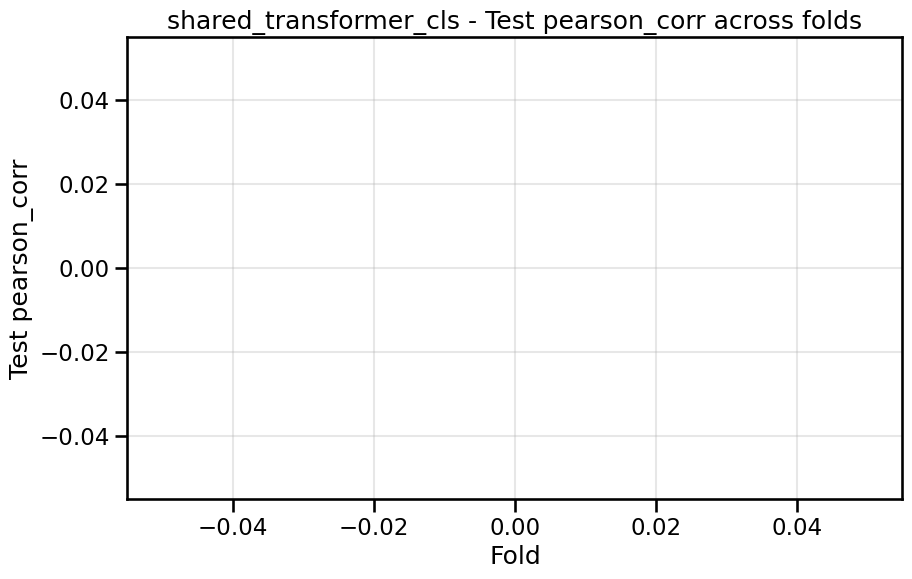

In [19]:
# Function to plot test performance across folds for a specific model type
def plot_model_folds_performance(df, model_type, metric='pearson_corr'):
    # Filter for the specific model type
    model_df = df[df['model_type'] == model_type].copy()
    
    # Extract fold numbers from the Name column
    model_df['fold'] = model_df['Name'].str.extract(r'fold(\d+)').astype(int)
    
    # Sort by fold number
    model_df = model_df.sort_values('fold')
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    metric_col = f'final_test_metrics.{metric}'
    plt.bar(model_df['fold'], model_df[metric_col])
    
    # Customize the plot
    plt.title(f'{model_type} - Test {metric} across folds')
    plt.xlabel('Fold')
    plt.ylabel(f'Test {metric}')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on top of each bar
    for i, v in enumerate(model_df[metric_col]):
        plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.show()

# Example usage - plot pearson correlation for shared_transformer
plot_model_folds_performance(filtered_df, 'shared_transformer_cls', 'pearson_corr')
